# LA County Board of Supervisors - Campaign Donations Maps

These maps visualize campaign donations made in 2018 and 2019 to the candidates running for the Board of Supervisors, including races involving incumbents Kathryn Barger and Janice Hahn and one open seat being vacated by Mark Ridley-Thomas.  

In [108]:
"""
A Los Angeles Times theme for Altair.
"""
# Color schemes and defaults
palette = dict(
    black='#000000',
    white='#ffffff',
    default='#82c6df',
    accent='#006d8f',
    highlight='#ec8431',
    democrat='#5789b8',
    republican='#d94f54',
    schemes={
      'category-6': [
        '#3580b1',
        '#ec8431',
        '#ab7fb4',
        '#c89d29',
        '#adc839',
        '#829eb1',
      ],
      'fire-7': [
        '#fbf2c7',
        '#f9e39c',
        '#f8d36e',
        '#f4bb6a',
        '#e68a4f',
        '#d15a40',
        '#ab4232',
      ],
      'fireandice-6': [
        '#e68a4f',
        '#f4bb6a',
        '#f9e39c',
        '#dadfe2',
        '#a6b7c6',
        '#849eae',
      ],
      'ice-7': [
        '#edefee',
        '#dadfe2',
        '#c4ccd2',
        '#a6b7c6',
        '#849eae',
        '#607785',
        '#47525d',
      ],
    }
)


def theme():
    """
    A Los Angeles Times theme for Altair.
    """
    # Headline stuff
    headlineFontSize = 50
    headlineFontWeight = "normal"
    headlineFont = 'Benton Gothic Bold, sans'

    # Titles for axes and legends and such
    titleFont = 'Benton Gothic Bold, sans'
    titleFontWeight = 'normal'
    titleFontSize = 100

    # Labels for ticks and legend entries and such
    labelFont = 'Benton Gothic, sans'
    labelFontSize = 12
    labelFontWeight = 'normal'

    return dict(
        config=dict(
            view=dict(
                width=800,
                height=450
            ),
            background=palette['white'],
            title=dict(
                anchor='start',
                font=headlineFont,
                fontColor=palette['black'],
                fontSize=headlineFontSize,
                fontWeight=headlineFontWeight,
                Y=-5
            ),
            arc=dict(fill=palette['default']),
            area=dict(fill=palette['default']),
            line=dict(stroke=palette['default'], strokeWidth=3),
            path=dict(stroke=palette['default']),
            rect=dict(fill=palette['default']),
            shape=dict(stroke=palette['default']),
            bar=dict(fill=palette['default']),
            point=dict(stroke=palette['default']),
            symbol=dict(fill=palette['default'], size=30),
            axis=dict(
                titleFont=titleFont,
                titleFontSize=titleFontSize,
                titleFontWeight=titleFontWeight,
                labelFont=labelFont,
                labelFontSize=labelFontSize,
                labelFontWeight=labelFontWeight
            ),
            axisX=dict(
                labelAngle=0,
                labelPadding=4,
                tickSize=3
            ),
            axisY=dict(
                labelBaseline='middle',
                maxExtent=45,
                minExtent=45,
                tickSize=2,
                titleAlign='left',
                titleAngle=0,
                titleX=-45,
                titleY=-5
            ),
            legend=dict(
                titleFont=titleFont,
                titleFontSize=titleFontSize,
                titleFontWeight=titleFontWeight,
                symbolType='square',
                labelFont=labelFont,
                labelFontSize=labelFontSize + 1
            ),
            range=dict(
                category=palette['schemes']['category-6'],
                diverging=palette['schemes']['fireandice-6'],
                heatmap=palette['schemes']['fire-7'],
                ordinal=palette['schemes']['fire-7'],
                ramp=palette['schemes']['fire-7']
            )
        )
    )

In [109]:
import pandas as pd
import psycopg2 as pg
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
import sqlalchemy
import pandas.io.sql as psql
import numpy as np
import geopandas 
import descartes
import geojson
import scheme
import mapclassify
import json
import pysal as ps
import jenkspy
import altair as alt
alt.renderers.enable('notebook')
alt.themes.enable('opaque')
# import geopandas as gpd
# import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')


ThemeRegistry.enable('latimes')

### Get the data from our larger donations database of committees in all countywide races back to 2007. 

In [110]:
database_con = pg.connect("dbname=campaigns user=postgres")

In [111]:
alldonations =  psql.read_sql("SELECT * FROM contributions", database_con)

### Let's clean up the spaces and capitalization in field names

In [112]:
alldonations.columns = alldonations.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [113]:
alldonations.head(2)

,last_name,first_name,committee_id,committee_name,office_type,district_number,schedule,type,date,amount_rcvd,...,employer,int_name,int_city,int_state,int_zip_code,int_occupation,int_employer,doc_id,rec_id,x
0,Barger,Kathryn,1414462,Kathryn Barger for Supervisor 2020,CSU,C05,A,I,2018-12-31,-1500.0,...,Miller Barondess LLP,,,,,,,,2557,164955
1,Barger,Kathryn,1414462,Kathryn Barger for Supervisor 2020,CSU,C05,A,I,2018-12-31,-250.0,...,"Miller Barondess, LLP",,,,,,,,2557,164953


### Some date parsing

In [114]:
alldonations['date'] = pd.to_datetime(alldonations['date'], errors='coerce')

In [115]:
alldonations['year'], alldonations['month'] = alldonations['date'].dt.year, alldonations['date'].dt.month
alldonations['year'] = alldonations['year'].astype(str)
alldonations['month'] = alldonations['month'].astype(str)
alldonations['amount_rcvd'] = alldonations['amount_rcvd'].astype(int)
alldonations['monthyear'] = pd.to_datetime(alldonations['date']).map(lambda dt: dt.replace(day=1))


### Filter out older contributions.

In [116]:
nudonations = alldonations[alldonations.date > '2018-06-30']

### Aggregate by month/year to make sure we filter appropriately. 

In [117]:
nudonations[['date', 'amount_rcvd']].groupby(nudonations.date.dt.to_period("M")).agg(['sum', 'size', 'mean'])

amount_rcvd                   
                sum  size         mean
date                                  
2018-07       87659   150   584.393333
2018-08      232188   323   718.848297
2018-09      304368   473   643.484144
2018-10      609077   803   758.501868
2018-11      176696   207   853.603865
2018-12      859396   700  1227.708571
2019-01      179180   187   958.181818
2019-02      607890   697   872.152080
2019-03      479805   509   942.642436
2019-04      419783   563   745.618117
2019-05      545495   706   772.655807
2019-06     1003559  1398   717.853362

## Three stories: Group 2020 contributions data by 1) race, 2) time, 3) zip code.

### Select only donations to candidates running in 2020

In [118]:
thiscycle = nudonations[(nudonations['date'] > '2018-06-30') & (nudonations['committee_name'].str.contains('2020', case = False)
)] 

In [119]:
thiscycle.groupby('committee_name').agg(['sum', 'size', 'mean'])

amount_rcvd       \
                                                           sum size   
committee_name                                                        
Committee to Re-Elect Jackie Lacey for District...      433480  444   
Holly J. Mitchell for County Supervisor 2020            564594  767   
JAN PERRY FOR SUPERVISOR 2020 DISTRICT 2                509760  893   
Janice Hahn for Supervisor 2020                         322850  275   
Jeong for County Supervisor 2020                         46100   82   
Joseph F. Iniguez for District Attorney 2020             48195  181   
Kathryn Barger for Supervisor 2020                      815095  935   
Wesson for Supervisor 2020                             1119445  960   

                                                                amount_pd  \
                                                           mean       sum   
committee_name                                                              
Committee to Re-Elect Jackie Lacey for District...   976.306306       0.0   
Holly J. Mitchell for County Supervisor 2020         736.106910       0.0   
JAN PERRY FOR SUPERVISOR 2020 DISTRICT 2             570.839866       0.0   
Janice Hahn for Supervisor 2020                     1174.000000       0.0   
Jeong for County Supervisor 2020                     562.195122       0.0   
Joseph F. Iniguez for District Attorney 2020         266.270718       0.0   
Kathryn Barger for Supervisor 2020                   871.759358       0.0   
Wesson for Supervisor 2020                          1166.088542       0.0   

                                                              
                                                   size mean  
committee_name                                                
Committee to Re-Elect Jackie Lacey for District...  444  0.0  
Holly J. Mitchell for County Supervisor 2020        767  0.0  
JAN PERRY FOR SUPERVISOR 2020 DISTRICT 2            893  0.0  
Janice Hahn for Supervisor 2020                     275  0.0  
Jeong for County Supervisor 2020                     82  0.0  
Joseph F. Iniguez for District Attorney 2020        181  0.0  
Kathryn Barger for Supervisor 2020                  935  0.0  
Wesson for Supervisor 2020                          960  0.0

In [120]:
thiscycle.head(3)

,last_name,first_name,committee_id,committee_name,office_type,district_number,schedule,type,date,amount_rcvd,...,int_state,int_zip_code,int_occupation,int_employer,doc_id,rec_id,x,year,month,monthyear
0,Barger,Kathryn,1414462,Kathryn Barger for Supervisor 2020,CSU,C05,A,I,2018-12-31,-1500,...,,,,,,2557,164955,2018,12,2018-12-01
1,Barger,Kathryn,1414462,Kathryn Barger for Supervisor 2020,CSU,C05,A,I,2018-12-31,-250,...,,,,,,2557,164953,2018,12,2018-12-01
2,Barger,Kathryn,1414462,Kathryn Barger for Supervisor 2020,CSU,C05,A,I,2018-12-31,100,...,,,,,,2557,164852,2018,12,2018-12-01


### 1) Create a dataframe with summary stats for each campaign this cycle

In [121]:
thiscycletotals = thiscycle.groupby(['first_name','last_name', 'committee_name'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

### 1) Clean up the hierarchical column structure. Standardize names in all caps.

In [122]:
flat_columns = [''.join(t) for t in thiscycletotals.columns]
thiscycletotals.columns = flat_columns
thiscycletotals['amount_rcvdmean'] = thiscycletotals['amount_rcvdmean'].round(0)
thiscycletotals['last_name'] = thiscycletotals['last_name'].str.upper()
thiscycletotals['committee_name'] = thiscycletotals['committee_name'].str.upper()
thiscycletotals['first_name'] = thiscycletotals['first_name'].str.upper()

thiscycletotals

,first_name,last_name,committee_name,amount_rcvdsize,amount_rcvdmean,amount_rcvdsum
0,CHAN,JEONG,JEONG FOR COUNTY SUPERVISOR 2020,82,562.0,46100
1,HERB,WESSON,WESSON FOR SUPERVISOR 2020,960,1166.0,1119445
2,HOLLY J.,MITCHELL,HOLLY J. MITCHELL FOR COUNTY SUPERVISOR 2020,767,736.0,564594
3,JAN,PERRY,JAN PERRY FOR SUPERVISOR 2020 DISTRICT 2,893,571.0,509760
4,JACQUELYN,LACEY,COMMITTEE TO RE-ELECT JACKIE LACEY FOR DISTRIC...,444,976.0,433480
5,JANICE,HAHN,JANICE HAHN FOR SUPERVISOR 2020,275,1174.0,322850
6,JOSEPH F.,INIGUEZ,JOSEPH F. INIGUEZ FOR DISTRICT ATTORNEY 2020,181,266.0,48195
7,KATHRYN,BARGER,KATHRYN BARGER FOR SUPERVISOR 2020,935,872.0,815095


***

## 2) When were the donations given during the time period?

In [123]:
thiscycletime = thiscycle.groupby(['monthyear','year','month', 'last_name'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

In [124]:
thiscycletime
flat_columns = [''.join(t) for t in thiscycletime.columns]
thiscycletime.columns = flat_columns
thiscycletime['amount_rcvdmean'] = thiscycletime['amount_rcvdmean'].astype(int)
thiscycletime['amount_rcvdmean'] = thiscycletime['amount_rcvdmean'].round()
thiscycletime.head(10)
thiscycletime['months'] = thiscycletime['monthyear'].dt.strftime('%m/%d/%Y').astype(str)


thiscycletime

,monthyear,year,month,last_name,amount_rcvdsize,amount_rcvdmean,amount_rcvdsum,months
0,2018-11-01,2018,11,Lacey,5,1100,5500,11/01/2018
1,2018-12-01,2018,12,Barger,213,1146,244150,12/01/2018
2,2018-12-01,2018,12,Hahn,6,700,4200,12/01/2018
3,2018-12-01,2018,12,Lacey,94,1276,120000,12/01/2018
4,2018-12-01,2018,12,Wesson,357,1275,455299,12/01/2018
5,2019-01-01,2019,1,Barger,11,1077,11850,01/01/2019
6,2019-01-01,2019,1,Hahn,1,1500,1500,01/01/2019
7,2019-01-01,2019,1,Lacey,13,1269,16500,01/01/2019
8,2019-01-01,2019,1,PERRY,59,642,37930,01/01/2019
9,2019-01-01,2019,1,Wesson,78,1048,81800,01/01/2019


### Individual dataframes for each candidate

In [125]:
bargerall = thiscycle[(thiscycle.last_name == 'Barger')]
hahnall = thiscycle[(thiscycle.last_name == 'Hahn')]
perryall = thiscycle[(thiscycle.last_name == 'PERRY')]
wessonall = thiscycle[(thiscycle.last_name == 'Wesson')]
iniguezall = thiscycle[(thiscycle.last_name == 'Iniguez')]
jeongall = thiscycle[(thiscycle.last_name == 'Jeong')]
mitchellall = thiscycle[(thiscycle.last_name == 'Mitchell')]

## Let's make some charts
### Totals donations collected by 2020 supervisor candidates since last summer

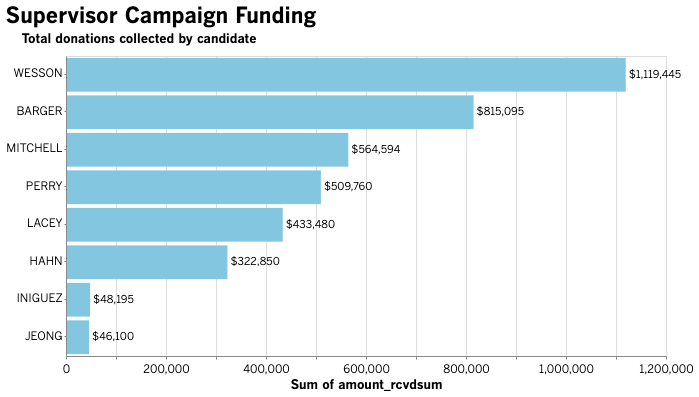

In [126]:
bars = alt.Chart(thiscycletotals, title="Supervisor Campaign Funding").mark_bar().encode(
    x='sum(amount_rcvdsum):Q',
    y=alt.Y(
        'last_name:N',
        title="Total donations collected by candidate",
        sort=alt.EncodingSortField(
            field="amount_rcvdsum",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending",  # The order to sort in
    )
)
)

text = bars.mark_text(
    align='left',
    font='Benton Gothic, sans',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('amount_rcvdsum:Q', format="$,")
)
    
(bars + text).properties(height=300, width=600)

### What's the average donation size? 

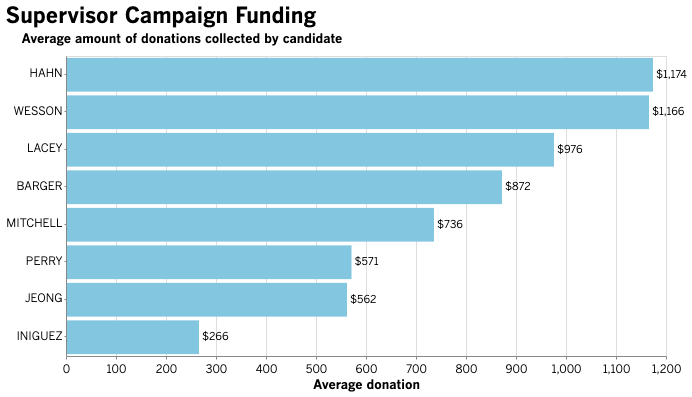

In [127]:
bars = alt.Chart(thiscycletotals, title="Supervisor Campaign Funding").mark_bar().encode(
    x=alt.X(
        'sum(amount_rcvdmean):Q',
        title="Average donation"),
    y=alt.Y(
        'last_name:N',
        title="Average amount of donations collected by candidate",
        sort=alt.EncodingSortField(
            field="amount_rcvdmean",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending",  # The order to sort in
    )
)
)

text = bars.mark_text(
    align='left',
    font='Benton Gothic, sans',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('amount_rcvdmean:Q', format="$,")
)
    
(bars + text).properties(height=300, width=600)

### How many donations have the candidates received? 

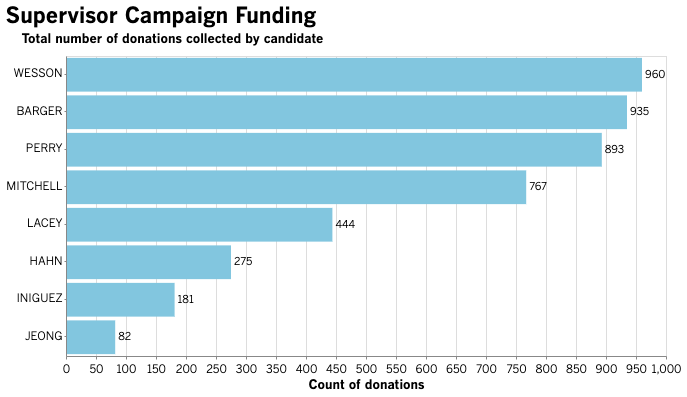

In [128]:
bars = alt.Chart(thiscycletotals, title="Supervisor Campaign Funding").mark_bar().encode(
    x=alt.X(
        'sum(amount_rcvdsize):Q',
        title="Count of donations"),
    y=alt.Y(
        'last_name:N',
        title="Total number of donations collected by candidate",
        sort=alt.EncodingSortField(
            field="amount_rcvdsize",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending",  # The order to sort in
        )
    )
)

text = bars.mark_text(
    align='left',
    font='Benton Gothic, sans',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('amount_rcvdsize:Q', format=",")
)
    
(bars + text).properties(height=300, width=600)

### Sum of donations by month

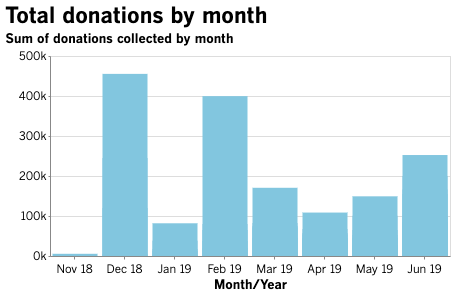

In [129]:
bars = alt.Chart(thiscycletime, title="Total donations by month").mark_bar().encode(
    x=alt.X("months:O", 
            timeUnit="yearmonth",
            title="Month/Year",
            axis=alt.Axis(format="%b %y")
           ),
    y=alt.Y(
        'amount_rcvdsum:Q',
        title="Sum of donations collected by month",
        axis=alt.Axis(format="1s")
        )
    )

(bars).properties(height=200, width=400) 

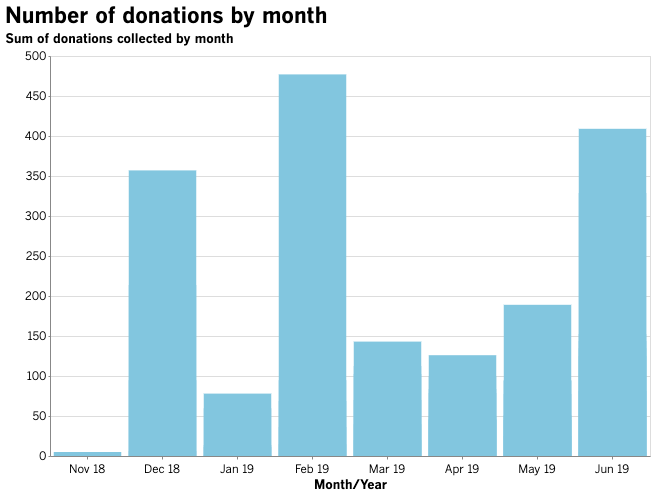

In [130]:
bars = alt.Chart(thiscycletime, title="Number of donations by month").mark_bar().encode(
    x=alt.X("months:O", 
            timeUnit="yearmonth",
            title="Month/Year",
            axis=alt.Axis(format="%b %y")
           ),
    y=alt.Y(
        'amount_rcvdsize:Q',
        title="Sum of donations collected by month",
        sort=alt.EncodingSortField(
            field="amount_rcvdsize",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending",  # The order to sort in
        )
    )
)

(bars).properties(height=400, width=600)

In [131]:
thiscycletime

,monthyear,year,month,last_name,amount_rcvdsize,amount_rcvdmean,amount_rcvdsum,months
0,2018-11-01,2018,11,Lacey,5,1100,5500,11/01/2018
1,2018-12-01,2018,12,Barger,213,1146,244150,12/01/2018
2,2018-12-01,2018,12,Hahn,6,700,4200,12/01/2018
3,2018-12-01,2018,12,Lacey,94,1276,120000,12/01/2018
4,2018-12-01,2018,12,Wesson,357,1275,455299,12/01/2018
5,2019-01-01,2019,1,Barger,11,1077,11850,01/01/2019
6,2019-01-01,2019,1,Hahn,1,1500,1500,01/01/2019
7,2019-01-01,2019,1,Lacey,13,1269,16500,01/01/2019
8,2019-01-01,2019,1,PERRY,59,642,37930,01/01/2019
9,2019-01-01,2019,1,Wesson,78,1048,81800,01/01/2019
